<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/DHOD/blob/master/nb/Zheng2007_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of Zheng2007 in diffhod 
This notebook illustrates how to implenent Zheng2007, and compare the results to halotools

## Preliminary setup


Here we download and install all the requirements

In [2]:
!pip install halotools
!download_initial_halocat.py 
!pip install --upgrade git+https://github.com/DifferentiableUniverseInitiative/DHOD.git

  Using cached halotools-0.7.tar.gz (7.6 MB)
^C
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/home/ben.horowitz/.local/bin/download_initial_halocat.py", line 72, in <module>
    raise HalotoolsError(existing_fname_error_msg % matching_fname)
halotools.custom_exceptions.HalotoolsError: 

The following filename already exists in your cache log: 

/home/ben.horowitz/.astropy/cache/halotools/halo_catalogs/bolshoi/rockstar/hlist_1.00035.list.halotools_v0p4.hdf5

If you really want to overwrite the file, 
execute this script again but throw the ``-overwrite`` flag.


  Cloning https://github.com/DifferentiableUniverseInitiative/DHOD.git to /tmp/pip-req-build-7743aak4
  Running command git clone -q https://github.com/DifferentiableUniverseInitiative/DHOD.git /tmp/pip-req-build-7743aak4
^C
ERROR: Operation cancelled by user


In [1]:
%pylab inline
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
from tensorflow_probability import edward2 as ed
from diffhod.components import Zheng07Cens, Zheng07SatsRelaxedBernoulli, NFWProfile
from halotools.sim_manager import CachedHaloCatalog
from halotools.empirical_models import PrebuiltHodModelFactory
from halotools.mock_observables.two_point_clustering import tpcf
from halotools.mock_observables import return_xyz_formatted_array

Populating the interactive namespace from numpy and matplotlib


/home/ben.horowitz/miniconda3/envs/DHOD/lib/python3.8/site-packages/diffhod-0.1-py3.8.egg/diffhod/components.py:9: UserWarning: tfp.edward2 module is deprecated and will be removed on 2019-12-01. Use https://github.com/google/edward2 library instead.


## Prepare halo catalog

In [2]:
# Load a reference halo catalog
halocat = CachedHaloCatalog(simname = 'bolshoi', redshift=-0.003) 

# Removing subhalos and convert table to tensors
halo_table = halocat.halo_table
halo_table = halo_table[halo_table['halo_pid'] == -1]
tf_halocat = {k: tf.convert_to_tensor(halo_table[k], dtype=tf.float32) for k in halo_table.colnames}

## Model definition

In [3]:
# We first load our reference halotools model
zheng07_model = PrebuiltHodModelFactory('zheng07', 
                                        redshift =-0.003, 
                                        modulate_with_cenocc=True)

In [4]:
# Here is how we define the same model in diffhod
@tf.function
def hod(halo_cat, max_sat=40, temp=0.1):

  ### Occupation model ###
  n_cen = Zheng07Cens(halo_cat['halo_mvir'],
                      **zheng07_model.param_dict,
                      temperature=temp)
  
  n_sat = Zheng07SatsRelaxedBernoulli(halo_cat['halo_mvir'],
                                      n_cen,
                                      **zheng07_model.param_dict,
                                      sample_shape=(max_sat,),
                                      temperature=temp)
  
  ### Phase Space model ###
  # Centrals are just located at center of halo
  pos_cen = ed.Deterministic(tf.stack([halo_cat['halo_x'],
                                        halo_cat['halo_y'],
                                        halo_cat['halo_z']], axis=-1))
  # Satellites follow an NFW profile centered on halos
  pos_sat = NFWProfile(pos=pos_cen,
                        concentration=halo_cat['halo_nfw_conc'],
                        Rvir=halo_cat['halo_rvir'],
                        sample_shape=(max_sat,))
  
  return {'pos_cen':pos_cen, 'pos_sat':pos_sat, 'n_cen':n_cen, 'n_sat':n_sat}

In [5]:
# sampling galaxies from the model
gal_cat = hod(tf_halocat)

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


In [6]:
# Same thing with halotools
zheng07_model.populate_mock(halocat) 

## Testing 2pt function

In [7]:
# Let's define halotools samples
ht_sample = return_xyz_formatted_array(zheng07_model.mock.galaxy_table['x'],
                                       zheng07_model.mock.galaxy_table['y'],
                                       zheng07_model.mock.galaxy_table['z'])
m = zheng07_model.mock.galaxy_table['host_centric_distance'] <0.0001
ht_cens = ht_sample[m]
ht_sats = ht_sample[~m]

In [8]:
# Same thing for dhod
p = gal_cat['n_cen']>0.5
tf_cens = gal_cat['pos_cen'][p].numpy()
p = gal_cat['n_sat']>0.5
tf_sats = gal_cat['pos_sat'][p].numpy().reshape((-1,3))
tf_sample = np.concatenate([tf_cens, tf_sats], axis=0)

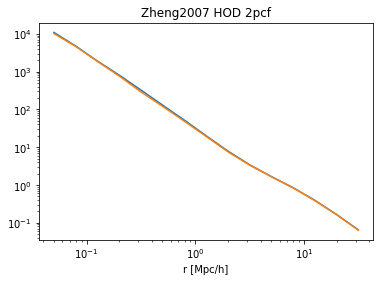

In [9]:
rbins = np.logspace(-1.5, 1.5, 16)
xi_ht = tpcf(ht_sample, rbins, period=halocat.Lbox)
xi_tf = tpcf(tf_sample, rbins, period=halocat.Lbox)

loglog(rbins[1:],xi_ht, label='halotools')
loglog(rbins[1:],xi_tf, label='DHOD')
xlabel('r [Mpc/h]')
title('Zheng2007 HOD 2pcf');

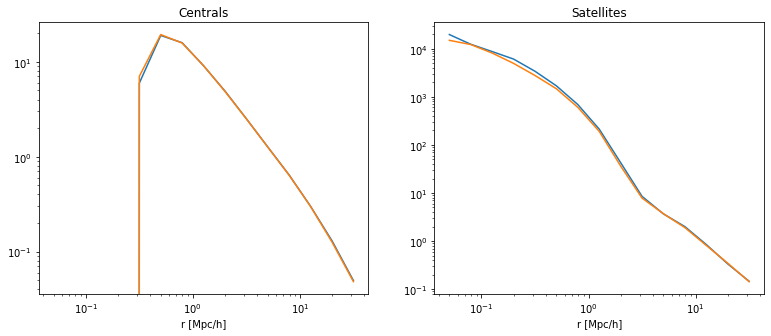

In [10]:
xi_ht_cen = tpcf(ht_cens, rbins, period=halocat.Lbox)
xi_tf_cen = tpcf(tf_cens, rbins, period=halocat.Lbox)
xi_ht_sat = tpcf(ht_sats, rbins, period=halocat.Lbox)
xi_tf_sat = tpcf(tf_sats, rbins, period=halocat.Lbox)

figure(figsize=(13,5))
subplot(121)
loglog(rbins[1:],xi_ht_cen, label='halotools')
loglog(rbins[1:],xi_tf_cen, label='DHOD')
xlabel('r [Mpc/h]')
title('Centrals');

subplot(122)
loglog(rbins[1:],xi_ht_sat, label='halotools')
loglog(rbins[1:],xi_tf_sat, label='DHOD')
xlabel('r [Mpc/h]')
title('Satellites');

## POWERSPECTRA

In [11]:
#TF2 compatable painter
def cic_paint(mesh, part, weight=None, name="CiCPaint"):
  """
  Paints particules on a 3D mesh.
  Parameters:
  -----------
  mesh: tensor (batch_size, nc, nc, nc)
    Input 3D mesh tensor
  part: tensor (batch_size, npart, 3)
    List of 3D particle coordinates, assumed to be in mesh units if
    boxsize is None
  weight: tensor (batch_size, npart)
    List of weights  for each particle
  """
  with tf.name_scope(name):
    mesh = tf.convert_to_tensor(mesh, name="mesh")
    part = tf.convert_to_tensor(part, name="part")
    if weight is not None:
      weight = tf.convert_to_tensor(weight, name="weight")

    shape = tf.shape(mesh)
    batch_size, nx, ny, nz = shape[0], shape[1], shape[2], shape[3]
    nc = nz

    # Flatten part if it's not already done
    if len(part.shape) > 3:
      part = tf.reshape(part, (batch_size, -1, 3))

    # Extract the indices of all the mesh points affected by each particles
    part = tf.expand_dims(part, 2)
    floor = tf.floor(part)
    connection = tf.expand_dims(tf.constant([[[0, 0, 0], [1., 0, 0],[0., 1, 0],
                                              [0., 0, 1],[1., 1, 0],[1., 0, 1],
                                              [0., 1, 1],[1., 1, 1]]]), 0)

    neighboor_coords = floor + connection
    kernel = 1. - tf.abs(part - neighboor_coords)
    # Replacing the reduce_prod op by manual multiplication
    # TODO: figure out why reduce_prod was crashing the Hessian computation
    kernel = kernel[..., 0] * kernel[..., 1] * kernel[..., 2]

    if weight is not None: kernel = tf.multiply(tf.expand_dims(weight, axis=-1) , kernel)

    neighboor_coords = tf.cast(neighboor_coords, tf.int32)
    neighboor_coords = tf.math.mod(neighboor_coords , nc)

    # Adding batch dimension to the neighboor coordinates
    batch_idx = tf.range(0, batch_size)
    batch_idx = tf.reshape(batch_idx, (batch_size, 1, 1, 1))
    b = tf.tile(batch_idx, [1] + list(neighboor_coords.get_shape()[1:-1]) + [1])
    neighboor_coords = tf.concat([b, neighboor_coords], axis=-1)

    update = tf.scatter_nd(tf.reshape(neighboor_coords, (-1, 8,4)),tf.reshape(kernel, (-1, 8)),[batch_size, nx, ny, nz])
    mesh = mesh + update
    return mesh


In [12]:
p = gal_cat['n_cen']>0.5
tf_cens = gal_cat['pos_cen'][p]

In [13]:
bs = gal_cat['n_cen'].shape

In [14]:
gal_cat['pos_sat'].shape, gal_cat['pos_cen'].shape

(TensorShape([40, 1033105, 3]), TensorShape([1033105, 3]))

In [23]:
bs = 128

sample1 = gal_cat['pos_cen']/250*bs
sample1_r = tf.tile(tf.expand_dims(sample1,0),[1,1,1])

sample2 = tf.reshape(gal_cat['pos_sat'], [-1,3])/250*bs
sample2_r = tf.tile(tf.expand_dims(sample2,0),[1,1,1])

In [24]:
sample1_r.shape

TensorShape([1, 1033105, 3])

In [25]:
painted_central_tf =cic_paint(tf.zeros((1, bs, bs, bs)),sample1_r,weight=gal_cat['n_cen'])
painted_sat_tf =cic_paint(tf.zeros((1, bs, bs, bs)),sample2_r,weight=tf.reshape(gal_cat['n_sat'], [-1,]))

In [26]:
painted_central_hod = cic_paint(tf.zeros((1, bs, bs, bs)),ht_cens.reshape(1,-1,3)/250*bs)
painted_sat_hod = cic_paint(tf.zeros((1, bs, bs, bs)),ht_sats.reshape(1,-1,3)/250*bs)

In [27]:
np.sum(painted_central_hod ),np.sum(painted_central_tf)

(57878.02, 58133.797)

In [42]:
np.sum(painted_sat_hod ),np.sum(painted_sat_tf)

(15516.001, 15971.88)

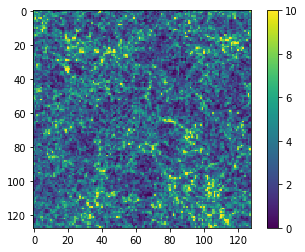

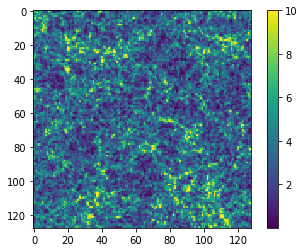

In [37]:
imshow(painted_central_hod[0].numpy().sum(axis=1),vmax=10)
colorbar()
show()
imshow(painted_central_tf[0].numpy().sum(axis=1),vmax=10)
colorbar()


In [39]:
np.save("central_hod",painted_central_hod)
np.save("sat_hod",painted_sat_hod)
np.save("central_tf",painted_central_tf)
np.save("sat_tf",painted_sat_tf)